In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-whitegrid', 'dark_background', 'seaborn-pastel', 'grayscale', 'seaborn-darkgrid', 'fivethirtyeight', '_classic_test', 'seaborn-bright', 'seaborn-talk', 'seaborn-deep', 'seaborn-poster', 'classic', 'Solarize_Light2', 'seaborn-paper', 'seaborn', 'fast', 'seaborn-notebook', 'seaborn-dark', 'seaborn-muted', 'seaborn-colorblind', 'bmh', 'seaborn-ticks', 'seaborn-white', 'seaborn-dark-palette', 'ggplot']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

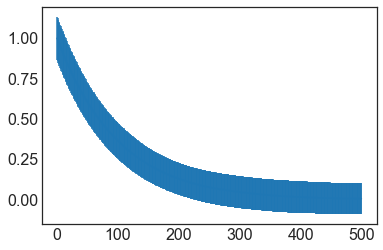

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

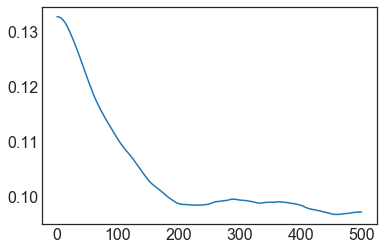

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [28]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[1,1],
                            out.values['amplitude'],
                            out.covar[0,0],
                            out.covar[0,1]])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[1,1],
                            out2.values['amplitude'],
                            out2.covar[0,0],
                            out.covar[0,1]])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    amplitude:  0.80861653 +/- 0.00548768 (0.68%) (init = 0.9128493)
    decay:      99.3939795 +/- 0.95998507 (0.97%) (init = 92.62367)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    amplitude:  0.79842635 +/- 0.00669521 (0.84%) (init = 0.9128493)
    decay:      101


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 33.8773073
    reduced chi-square = 0.06802672
    Akaike info crit   = -1341.93135
    Bayesian info crit = -1333.50214
[[Variables]]
    amplitude:  0.83278875 +/- 0.00630927 (0.76%) (init = 0.6350753)
    decay:      104.564601 +/- 0.98496143 (0.94%) (init = 130.5466)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.724

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.91140693
    reduced chi-square = 0.00383817
    Akaike info crit   = -2779.38426
    Bayesian info crit = -2770.95504
[[Variables]]
    amplitude:  0.74156508 +/- 0.00960085 (1.29%) (init = 0.4790768)
    decay:      17


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.81166114
    reduced chi-square = 0.00162984
    Akaike info crit   = -3207.64022
    Bayesian info crit = -3199.21101
[[Variables]]
    amplitude:  1.26994149 +/- 0.00797184 (0.63%) (init = 0.8691822)
    decay:      100.773442 +/- 0.90038415 (0.89%) (init = 140.3718)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 84.2344506
    reduced chi-square = 0.16914548
    Akaike info crit   = -886.502054
    Bayesian info crit = -878.072838
[[Variables]]
    amplitude:  1.27250165 +/- 0.01016256 (0.80%) (init = 0.8691822)
    decay:      10

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 2.68133699
    reduced chi-square = 0.00538421
    Akaike info crit   = -2610.14628
    Bayesian info crit = -2601.71706
[[Variables]]
    amplitude:  1.10653074 +/- 0.01678192 (1.52%) (init = 0.6189684)
    decay:      74.4532243 +/- 1.60803915 (2.16%) (init = 132.4961)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 259.928560
    reduced chi-square = 0.52194490
    Akaike info crit   = -323.100637
    Bayesian info crit = -314.671420
[[Variables]]
    amplitude:  1.13577182 +/- 0.02130965 (1.88%) (init = 0.6189684)
    decay:      71.6400272 +/- 1.69544920 (2.37

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 52.8669219
    reduced chi-square = 0.10615848
    Akaike info crit   = -1119.41513
    Bayesian info crit = -1110.98591
[[Variables]]
    amplitude:  0.81821195 +/- 0.00705666 (0.86%) (init = 0.7379433)
    decay:      129.512530 +/- 1.39605627 (1.08%) (init = 136.5248)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.733

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 2.77988377
    reduced chi-square = 0.00558210
    Akaike info crit   = -2592.09949
    Bayesian info crit = -2583.67028
[[Variables]]
    amplitude:  1.19284147 +/- 0.01445795 (1.21%) (init = 0.6941919)
    decay:      105

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 2
    chi-square         = 731.857041
    reduced chi-square = 1.46959245
    Akaike info crit   = 194.488549
    Bayesian info crit = 202.917765
[[Variables]]
    amplitude:  1.31803413 +/- 0.02942293 (2.23%) (init = 0.6591989)
    decay:      103.887147 +/- 2.88409583 (2.78%) (init = 207.261)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.723

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 500
    # variables        = 2
    chi-square         = 0.98540184
    reduced chi-square = 0.00197872
    Akaike info crit   = -3110.65693
    Bayesian info crit = -3102.22771
[[Variables]]
    amplitude:  1.00310276 +/- 0.00945899 (0.94%) (init = 0.5119764)
    decay:      86.499

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 29.1722565
    reduced chi-square = 0.05857883
    Akaike info crit   = -1416.69498
    Bayesian info crit = -1408.26576
[[Variables]]
    amplitude:  0.82737637 +/- 0.00452187 (0.55%) (init = 0.8964652)
    decay:      175.371899 +/- 1.24291029 (0.71%) (init = 162.575)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.751

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 2.66664972
    reduced chi-square = 0.00535472
    Akaike info crit   = -2612.89260
    Bayesian info crit = -2604.46338
[[Variables]]
    amplitude:  1.14887286 +/- 0.01822619 (1.59%) (init = 0.2540254)
    decay:      62.4

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.26725573
    reduced chi-square = 5.3666e-04
    Akaike info crit   = -3763.07869
    Bayesian info crit = -3754.64948
[[Variables]]
    amplitude:  1.04332698 +/- 0.00451962 (0.43%) (init = 0.9765512)
    decay:      103.328230 +/- 0.63719175 (0.62%) (init = 102.3154)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 500
    # variables        = 2
    chi-square         = 26.2461122
    reduced chi-square = 0.05270304
    Akaike info crit   = -1469.54511
    Bayesian info crit = -1461.11590
[[Variables]]
    amplitude:  1.04983279 +/- 0.00561749 (0.54%) (init = 0.9765512)
    decay:      102.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 110.351369
    reduced chi-square = 0.22158909
    Akaike info crit   = -751.469282
    Bayesian info crit = -743.040066
[[Variables]]
    amplitude:  0.93519927 +/- 0.01518917 (1.62%) (init = 0.2442343)
    decay:      60.3010384 +/- 1.25034080 (2.07%) (init = 182.8946)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.23268370
    reduced chi-square = 0.00448330
    Akaike info crit   = -2701.70189
    Bayesian info crit = -2693.27268
[[Variables]]
    amplitude:  1.25180451 +/- 0.01132464 (0.90%) (init = 1.580751)
    decay:      140.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.84816945
    reduced chi-square = 0.00170315
    Akaike info crit   = -3185.64147
    Bayesian info crit = -3177.21225
[[Variables]]
    amplitude:  1.31964461 +/- 0.00880101 (0.67%) (init = 1.016277)
    decay:      85.9793475 +/- 0.81596763 (0.95%) (init = 86.32101)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 72.2404841
    reduced chi-square = 0.14506121
    Akaike info crit   = -963.303744
    Bayesian info crit = -954.874528
[[Variables]]
    amplitude:  1.34458274 +/- 0.01036448 (0.77%) (init = 1.016277)
    decay:      83.5492534 +/- 0.80547126 (0.96%)

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 2
    chi-square         = 571.412477
    reduced chi-square = 1.14741461
    Akaike info crit   = 70.7516134
    Bayesian info crit = 79.1808295
[[Variables]]
    amplitude:  1.01807102 +/- 0.02695037 (2.65%) (init = 0.4211579)
    decay:      96.9907385 +/- 3.19618481 (3.30%) (init = 248.848)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.721

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.92854489
    reduced chi-square = 0.00588061
    Akaike info crit   = -2566.05121
    Bayesian info crit = -2557.62199
[[Variables]]
    amplitude:  1.56336056 +/- 0.01509135 (0.97%) (init = 1.160383)
    decay:      101.490

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 2.71942112
    reduced chi-square = 0.00546068
    Akaike info crit   = -2603.09453
    Bayesian info crit = -2594.66532
[[Variables]]
    amplitude:  1.06228989 +/- 0.01591325 (1.50%) (init = 0.3452526)
    decay:      84.2816294 +/- 1.79645948 (2.13%) (init = 296.9957)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 282.611145
    reduced chi-square = 0.56749226
    Akaike info crit   = -281.268096
    Bayesian info crit = -272.838880
[[Variables]]
    amplitude:  1.04551020 +/- 0.02018093 (1.93%) (init = 0.3452526)
    decay:      86.0721228 +/- 2.07559016 (2.41

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 500
    # variables        = 2
    chi-square         = 30.4290835
    reduced chi-square = 0.06110258
    Akaike info crit   = -1395.60463
    Bayesian info crit = -1387.17541
[[Variables]]
    amplitude:  1.02575199 +/- 0.00698986 (0.68%) (init = 0.45916)
    decay:      77.6557603 +/- 0.66427012 (0.86%) (init = 143.1128)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.713

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 3.16058179
    reduced chi-square = 0.00634655
    Akaike info crit   = -2527.92599
    Bayesian info crit = -2519.49677
[[Variables]]
    amplitude:  1.07914112 +/- 0.01956171 (1.81%) (init = 0.3136254)
    decay:      64.32

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.47950987
    reduced chi-square = 9.6287e-04
    Akaike info crit   = -3470.79945
    Bayesian info crit = -3462.37023
[[Variables]]
    amplitude:  0.68586903 +/- 0.00535765 (0.78%) (init = 0.4937182)
    decay:      133.846530 +/- 1.49937225 (1.12%) (init = 197.2233)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.709

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 40.2754743
    reduced chi-square = 0.08087445
    Akaike info crit   = -1255.43270
    Bayesian info crit = -1247.00348
[[Variables]]
    amplitude:  0.66379240 +/- 0.00592166 (0.89%) (init = 0.4937182)
    decay:      140.036771 +/- 1.57008804 (1.12

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 0.26856288
    reduced chi-square = 5.3928e-04
    Akaike info crit   = -3760.63915
    Bayesian info crit = -3752.20994
[[Variables]]
    amplitude:  0.86300357 +/- 0.00589325 (0.68%) (init = 0.1560385)
    decay:      60.0857203 +/- 0.58515344 (0.97%) (init = 141.7087)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 25.1954523
    reduced chi-square = 0.05059328
    Akaike info crit   = -1489.97229
    Bayesian info crit = -1481.54308
[[Variables]]
    amplitude:  0.87395414 +/- 0.00735583 (0.84%) (init = 0.1560385)
    decay:      58.7641788 +/- 0.63264071 (1.08

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 500
    # variables        = 2
    chi-square         = 9.68022933
    reduced chi-square = 0.01943821
    Akaike info crit   = -1968.26125
    Bayesian info crit = -1959.83204
[[Variables]]
    amplitude:  1.18947170 +/- 0.02988593 (2.51%) (init = 0.3699076)
    decay:      85.0902053 +/- 3.04151280 (3.57%) (init = 352.2414)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 500
    # variables        = 2
    chi-square         = 994.445373
    reduced chi-square = 1.99687826
    Akaike info crit   = 347.788535
    Bayesian info crit = 356.217751
[[Variables]]
    amplitude:  1.22013745 +/- 0.03871343 (3.17%) (init = 0.3699076)
    decay:      82.5022963 +/- 3.27496611 (3.97%)

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 71.2160827
    reduced chi-square = 0.14300418
    Akaike info crit   = -970.444713
    Bayesian info crit = -962.015496
[[Variables]]
    amplitude:  0.76682898 +/- 0.01047973 (1.37%) (init = 0.734055)
    decay:      80.7023871 +/- 1.38165595 (1.71%) (init = 88.38826)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.40170649
    reduced chi-square = 8.0664e-04
    Akaike info crit   = -3559.32084
    Bayesian info crit = -3550.89163
[[Variables]]
    amplitude:  1.22019373 +/- 0.00594450 (0.49%) (init = 0.709609)
    decay:      89.35

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.63097092
    reduced chi-square = 0.00126701
    Akaike info crit   = -3333.55180
    Bayesian info crit = -3325.12258
[[Variables]]
    amplitude:  0.98535009 +/- 0.00676880 (0.69%) (init = 0.5770414)
    decay:      108.993352 +/- 1.06651449 (0.98%) (init = 159.5844)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 65.6572950
    reduced chi-square = 0.13184196
    Akaike info crit   = -1011.07969
    Bayesian info crit = -1002.65048
[[Variables]]
    amplitude:  0.98427564 +/- 0.00858619 (0.87%) (init = 0.5770414)
    decay:      109.214775 +/- 1.18463004 (1.08

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 343.223432
    reduced chi-square = 0.68920368
    Akaike info crit   = -184.113230
    Bayesian info crit = -175.684013
[[Variables]]
    amplitude:  0.85342307 +/- 0.01191296 (1.40%) (init = 0.8208653)
    decay:      347.617709 +/- 8.20026376 (2.36%) (init = 369.5759)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.803

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 0.93965441
    reduced chi-square = 0.00188686
    Akaike info crit   = -3134.42561
    Bayesian info crit = -3125.99639
[[Variables]]
    amplitude:  0.77108303 +/- 0.01219470 (1.58%) (init = 0.1425735)
    decay:      48.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 497.635641
    reduced chi-square = 0.99926836
    Akaike info crit   = 1.63003345
    Bayesian info crit = 10.0592496
[[Variables]]
    amplitude:  1.24451109 +/- 0.03024316 (2.43%) (init = 0.2418825)
    decay:      68.2374574 +/- 2.09859843 (3.08%) (init = 292.09)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 2.44575172
    reduced chi-square = 0.00491115
    Akaike info crit   = -2656.12779
    Bayesian info crit = -2647.69857
[[Variables]]
    amplitude:  0.95789710 +/- 0.01684797 (1.76%) (init = 0.1951402)
    decay:      67.1778

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 428.228595
    reduced chi-square = 0.85989678
    Akaike info crit   = -73.4754723
    Bayesian info crit = -65.0462561
[[Variables]]
    amplitude:  1.14328170 +/- 0.02900750 (2.54%) (init = 0.4072663)
    decay:      64.0243289 +/- 2.06396568 (3.22%) (init = 185.5865)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.47655474
    reduced chi-square = 9.5694e-04
    Akaike info crit   = -3473.89039
    Bayesian info crit = -3465.46117
[[Variables]]
    amplitude:  1.25706276 +/- 0.00504046 (0.40%) (init = 1.086004)
    decay:      152.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.27513009
    reduced chi-square = 5.5247e-04
    Akaike info crit   = -3748.55967
    Bayesian info crit = -3740.13046
[[Variables]]
    amplitude:  0.91752513 +/- 0.00477682 (0.52%) (init = 0.7198675)
    decay:      94.9527934 +/- 0.70340132 (0.74%) (init = 93.10698)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 27.5279915
    reduced chi-square = 0.05527709
    Akaike info crit   = -1445.70237
    Bayesian info crit = -1437.27315
[[Variables]]
    amplitude:  0.92532020 +/- 0.00601459 (0.65%) (init = 0.7198675)
    decay:      93.9772228 +/- 0.76079687 (0.81

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 2
    chi-square         = 173.974523
    reduced chi-square = 0.34934643
    Akaike info crit   = -523.849616
    Bayesian info crit = -515.420400
[[Variables]]
    amplitude:  0.89094183 +/- 0.01916144 (2.15%) (init = 0.2525241)
    decay:      59.7701160 +/- 1.64169954 (2.75%) (init = 202.4661)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 4.05043099
    reduced chi-square = 0.00813340
    Akaike info crit   = -2403.89240
    Bayesian info crit = -2395.46319
[[Variables]]
    amplitude:  1.18545894 +/- 0.01973933 (1.67%) (init = 0.4183019)
    decay:      81.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 76.4027133
    reduced chi-square = 0.15341910
    Akaike info crit   = -935.294944
    Bayesian info crit = -926.865728
[[Variables]]
    amplitude:  0.86372812 +/- 0.01074268 (1.24%) (init = 0.3062933)
    decay:      82.3127822 +/- 1.28128529 (1.56%) (init = 201.874)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 2.85655485
    reduced chi-square = 0.00573605
    Akaike info crit   = -2578.49590
    Bayesian info crit = -2570.06668
[[Variables]]
    amplitude:  0.76974162 +/- 0.01771471 (2.30%) (init = 0.2293404)
    decay:      71.0

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.01838199
    reduced chi-square = 0.00405298
    Akaike info crit   = -2752.15595
    Bayesian info crit = -2743.72674
[[Variables]]
    amplitude:  0.84692936 +/- 0.01129438 (1.33%) (init = 0.505888)
    decay:      126.228743 +/- 2.40715269 (1.91%) (init = 236.2351)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 181.267691
    reduced chi-square = 0.36399135
    Akaike info crit   = -503.316601
    Bayesian info crit = -494.887385
[[Variables]]
    amplitude:  0.79670121 +/- 0.01265447 (1.59%) (init = 0.505888)
    decay:      138.017834 +/- 2.75167936 (1.99%)

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.32370838
    reduced chi-square = 6.5002e-04
    Akaike info crit   = -3667.26017
    Bayesian info crit = -3658.83095
[[Variables]]
    amplitude:  0.94213792 +/- 0.00503027 (0.53%) (init = 0.7931216)
    decay:      100.948414 +/- 0.76712854 (0.76%) (init = 105.1846)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 32.4069194
    reduced chi-square = 0.06507414
    Akaike info crit   = -1364.11807
    Bayesian info crit = -1355.68885
[[Variables]]
    amplitude:  0.94523673 +/- 0.00629461 (0.67%) (init = 0.7931216)
    decay:      100.672076 +/- 0.83379558 (0.83


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 14.5957023
    reduced chi-square = 0.02930864
    Akaike info crit   = -1762.94049
    Bayesian info crit = -1754.51127
[[Variables]]
    amplitude:  1.18136932 +/- 0.00390736 (0.33%) (init = 1.687683)
    decay:      116.934119 +/- 0.48137256 (0.41%) (init = 90.90392)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.728

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.35056616
    reduced chi-square = 7.0395e-04
    Akaike info crit   = -3627.40697
    Bayesian info crit = -3618.97775
[[Variables]]
    amplitude:  1.19525553 +/- 0.00439037 (0.37%) (init = 1.076826)
    decay:      147.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 2.08891956
    reduced chi-square = 0.00419462
    Akaike info crit   = -2734.98056
    Bayesian info crit = -2726.55134
[[Variables]]
    amplitude:  1.00573788 +/- 0.01468020 (1.46%) (init = 0.3191001)
    decay:      75.8424515 +/- 1.57624781 (2.08%) (init = 203.915)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 200.642769
    reduced chi-square = 0.40289713
    Akaike info crit   = -452.541020
    Bayesian info crit = -444.111803
[[Variables]]
    amplitude:  1.03330731 +/- 0.01855933 (1.80%) (init = 0.3191001)
    decay:      72.8451345 +/- 1.64873999 (2.26%

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 242.080387
    reduced chi-square = 0.48610520
    Akaike info crit   = -358.669124
    Bayesian info crit = -350.239908
[[Variables]]
    amplitude:  0.84436969 +/- 0.01889434 (2.24%) (init = 0.3082648)
    decay:      84.1956397 +/- 2.35627601 (2.80%) (init = 231.728)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.716

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 2.36330794
    reduced chi-square = 0.00474560
    Akaike info crit   = -2673.27289
    Bayesian info crit = -2664.84368
[[Variables]]
    amplitude:  1.06285267 +/- 0.01351009 (1.27%) (init = 0.5784008)
    decay:      102.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 2.59451911
    reduced chi-square = 0.00520988
    Akaike info crit   = -2626.60346
    Bayesian info crit = -2618.17424
[[Variables]]
    amplitude:  0.97235086 +/- 0.01845337 (1.90%) (init = 0.3066021)
    decay:      59.1822310 +/- 1.60157706 (2.71%) (init = 203.0438)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 2
    chi-square         = 258.102283
    reduced chi-square = 0.51827768
    Akaike info crit   = -326.626073
    Bayesian info crit = -318.196857
[[Variables]]
    amplitude:  0.99433127 +/- 0.02390381 (2.40%) (init = 0.3066021)
    decay:      57.0755373 +/- 1.75853198 (3.08

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.29367839
    reduced chi-square = 5.8972e-04
    Akaike info crit   = -3715.93906
    Bayesian info crit = -3707.50984
[[Variables]]
    amplitude:  1.11742345 +/- 0.00461595 (0.41%) (init = 1.700413)
    decay:      109.089777 +/- 0.64192469 (0.59%) (init = 77.23443)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 26.4195334
    reduced chi-square = 0.05305127
    Akaike info crit   = -1466.25223
    Bayesian info crit = -1457.82301
[[Variables]]
    amplitude:  1.13116164 +/- 0.00549719 (0.49%) (init = 1.700413)
    decay:      107.296640 +/- 0.64828740 (0.60%)


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 184.579748
    reduced chi-square = 0.37064207
    Akaike info crit   = -494.263244
    Bayesian info crit = -485.834028
[[Variables]]
    amplitude:  1.12504000 +/- 0.01601462 (1.42%) (init = 0.5272409)
    decay:      89.1259203 +/- 1.58251558 (1.78%) (init = 176.9548)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.718

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.22291867
    reduced chi-square = 4.4763e-04
    Akaike info crit   = -3853.77819
    Bayesian info crit = -3845.34897
[[Variables]]
    amplitude:  0.76974012 +/- 0.00416563 (0.54%) (init = 0.7182735)
    decay:      10

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 1.55254599
    reduced chi-square = 0.00311756
    Akaike info crit   = -2883.35597
    Bayesian info crit = -2874.92676
[[Variables]]
    amplitude:  0.84946660 +/- 0.01304435 (1.54%) (init = 0.2726765)
    decay:      71.2776816 +/- 1.55872232 (2.19%) (init = 231.1908)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 159.633202
    reduced chi-square = 0.32054860
    Akaike info crit   = -566.864701
    Bayesian info crit = -558.435485
[[Variables]]
    amplitude:  0.84431577 +/- 0.01668526 (1.98%) (init = 0.2726765)
    decay:      71.7756879 +/- 1.78833798 (2.49


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 3.31377879
    reduced chi-square = 0.00665417
    Akaike info crit   = -2504.25947
    Bayesian info crit = -2495.83025
[[Variables]]
    amplitude:  1.03015477 +/- 0.02002590 (1.94%) (init = 0.3158261)
    decay:      64.3602072 +/- 1.78275930 (2.77%) (init = 221.3987)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 329.161172
    reduced chi-square = 0.66096621
    Akaike info crit   = -205.030292
    Bayesian info crit = -196.601076
[[Variables]]
    amplitude:  1.05725646 +/- 0.02591115 (2.45%) (init = 0.3158261)
    decay:      61

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.79452020
    reduced chi-square = 0.00159542
    Akaike info crit   = -3218.31248
    Bayesian info crit = -3209.88327
[[Variables]]
    amplitude:  0.95382035 +/- 0.00833616 (0.87%) (init = 0.7143521)
    decay:      89.8902702 +/- 1.11779380 (1.24%) (init = 117.6046)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 77.3699470
    reduced chi-square = 0.15536134
    Akaike info crit   = -929.004837
    Bayesian info crit = -920.575621
[[Variables]]
    amplitude:  0.93357424 +/- 0.01015223 (1.09%) (init = 0.7143521)
    decay:      92.7688678 +/- 1.25685419 (1.35

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 2.16853403
    reduced chi-square = 0.00435449
    Akaike info crit   = -2716.27836
    Bayesian info crit = -2707.84914
[[Variables]]
    amplitude:  1.13475492 +/- 0.01556408 (1.37%) (init = 0.3673546)
    decay:      69.8923802 +/- 1.36534795 (1.95%) (init = 214.0978)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 216.507805
    reduced chi-square = 0.43475463
    Akaike info crit   = -414.490751
    Bayesian info crit = -406.061535
[[Variables]]
    amplitude:  1.15292942 +/- 0.01995131 (1.73%) (init = 0.3673546)
    decay:      68.2245692 +/- 1.49394569 (2.19

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 0.75557836
    reduced chi-square = 0.00151723
    Akaike info crit   = -3243.43994
    Bayesian info crit = -3235.01072
[[Variables]]
    amplitude:  0.97044053 +/- 0.00932023 (0.96%) (init = 0.228999)
    decay:      67.8527417 +/- 0.92831077 (1.37%) (init = 144.0322)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 70.4790356
    reduced chi-square = 0.14152417
    Akaike info crit   = -975.646400
    Bayesian info crit = -967.217184
[[Variables]]
    amplitude:  0.98959599 +/- 0.01161193 (1.17%) (init = 0.228999)
    decay:      65.6758866 +/- 0.97762202 (1.49%)

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 4.38573954
    reduced chi-square = 0.00880671
    Akaike info crit   = -2364.12492
    Bayesian info crit = -2355.69570
[[Variables]]
    amplitude:  1.04762011 +/- 0.02098186 (2.00%) (init = 0.3080898)
    decay:      78.0075710 +/- 2.22429456 (2.85%) (init = 308.8082)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 500
    # variables        = 2
    chi-square         = 448.601986
    reduced chi-square = 0.90080720
    Akaike info crit   = -50.2360243
    Bayesian info crit = -41.8068081
[[Variables]]
    amplitude:  1.06898053 +/- 0.02715793 (2.54%) (init = 0.3080898)
    decay:      75.9379018 +/- 2.42397712 (3.19

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 188.579926
    reduced chi-square = 0.37867455
    Akaike info crit   = -483.543085
    Bayesian info crit = -475.113869
[[Variables]]
    amplitude:  1.12112639 +/- 0.01846299 (1.65%) (init = 0.3188904)
    decay:      69.3478910 +/- 1.44333612 (2.08%) (init = 187.0869)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.38105792
    reduced chi-square = 7.6518e-04
    Akaike info crit   = -3585.70600
    Bayesian info crit = -3577.27678
[[Variables]]
    amplitude:  0.93345135 +/- 0.00542923 (0.58%) (init = 0.6794052)
    decay:      102


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 290.813950
    reduced chi-square = 0.58396375
    Akaike info crit   = -266.962192
    Bayesian info crit = -258.532976
[[Variables]]
    amplitude:  1.11310729 +/- 0.02014831 (1.81%) (init = 0.3630919)
    decay:      88.7195625 +/- 2.00398007 (2.26%) (init = 198.716)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.718

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 1.47861359
    reduced chi-square = 0.00296910
    Akaike info crit   = -2907.75161
    Bayesian info crit = -2899.32239
[[Variables]]
    amplitude:  0.87296598 +/- 0.01318572 (1.51%) (init = 0.2734381)
    decay:      66.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.44300942
    reduced chi-square = 8.8958e-04
    Akaike info crit   = -3510.38617
    Bayesian info crit = -3501.95696
[[Variables]]
    amplitude:  0.91187641 +/- 0.00607606 (0.67%) (init = 0.6804803)
    decay:      94.4829734 +/- 0.89578526 (0.95%) (init = 131.4524)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 42.2103093
    reduced chi-square = 0.08475966
    Akaike info crit   = -1231.97181
    Bayesian info crit = -1223.54259
[[Variables]]
    amplitude:  0.89398972 +/- 0.00731683 (0.82%) (init = 0.6804803)
    decay:      97.2123204 +/- 0.99009376 (1.02

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 3.18263149
    reduced chi-square = 0.00639083
    Akaike info crit   = -2524.44987
    Bayesian info crit = -2516.02065
[[Variables]]
    amplitude:  0.94085481 +/- 0.01491186 (1.58%) (init = 0.5706301)
    decay:      113.491484 +/- 2.56388523 (2.26%) (init = 190.9551)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 331.643178
    reduced chi-square = 0.66595016
    Akaike info crit   = -201.274236
    Bayesian info crit = -192.845020
[[Variables]]
    amplitude:  0.95253595 +/- 0.01901068 (2.00%) (init = 0.5706301)
    decay:      112.390122 +/- 2.79030240 (2.48

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.55529901
    reduced chi-square = 0.00312309
    Akaike info crit   = -2882.47014
    Bayesian info crit = -2874.04093
[[Variables]]
    amplitude:  1.18812133 +/- 0.01158613 (0.98%) (init = 0.6940774)
    decay:      91.1173239 +/- 1.26444324 (1.39%) (init = 126.3591)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 153.531055
    reduced chi-square = 0.30829529
    Akaike info crit   = -586.352619
    Bayesian info crit = -577.923403
[[Variables]]
    amplitude:  1.20799252 +/- 0.01460091 (1.21%) (init = 0.6940774)
    decay:      89.1773571 +/- 1.34458864 (1.51

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 500
    # variables        = 2
    chi-square         = 27.3946743
    reduced chi-square = 0.05500939
    Akaike info crit   = -1448.12974
    Bayesian info crit = -1439.70052
[[Variables]]
    amplitude:  1.04055874 +/- 0.00613664 (0.59%) (init = 0.5315282)
    decay:      90.0317080 +/- 0.66215875 (0.74%) (init = 138.3679)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.718

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 500
    # variables        = 2
    chi-square         = 14.8636558
    reduced chi-square = 0.02984670
    Akaike info crit   = -1753.84454
    Bayesian info crit = -1745.41532
[[Variables]]
    amplitude:  1.12840985 +/- 0.03775488 (3.35%) (init = 0.3566491)
    decay:      81.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 57.6086779
    reduced chi-square = 0.11568008
    Akaike info crit   = -1076.46744
    Bayesian info crit = -1068.03823
[[Variables]]
    amplitude:  0.87077850 +/- 0.01032761 (1.19%) (init = 0.2181654)
    decay:      67.7777658 +/- 1.01743342 (1.50%) (init = 179.1685)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 2.21252213
    reduced chi-square = 0.00444282
    Akaike info crit   = -2706.23750
    Bayesian info crit = -2697.80828
[[Variables]]
    amplitude:  0.87622437 +/- 0.01430248 (1.63%) (init = 0.4844272)
    decay:      84.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.12200913
    reduced chi-square = 0.00426106
    Akaike info crit   = -2727.12238
    Bayesian info crit = -2718.69316
[[Variables]]
    amplitude:  0.82131581 +/- 0.01038333 (1.26%) (init = 0.5503919)
    decay:      160.899378 +/- 2.96242491 (1.84%) (init = 274.5904)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 179.679627
    reduced chi-square = 0.36080246
    Akaike info crit   = -507.716343
    Bayesian info crit = -499.287127
[[Variables]]
    amplitude:  0.77178096 +/- 0.01121712 (1.45%) (init = 0.5503919)
    decay:      175.560526 +/- 3.30913669 (1.88

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 42.6344646
    reduced chi-square = 0.08561137
    Akaike info crit   = -1226.97257
    Bayesian info crit = -1218.54336
[[Variables]]
    amplitude:  0.90843244 +/- 0.00599969 (0.66%) (init = 0.7620477)
    decay:      144.434880 +/- 1.20236863 (0.83%) (init = 166.7933)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.739

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 1.61459492
    reduced chi-square = 0.00324216
    Akaike info crit   = -2863.76200
    Bayesian info crit = -2855.33278
[[Variables]]
    amplitude:  1.03022243 +/- 0.01282769 (1.25%) (init = 0.2845398)
    decay:      76.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 78.1112205
    reduced chi-square = 0.15684984
    Akaike info crit   = -924.237192
    Bayesian info crit = -915.807975
[[Variables]]
    amplitude:  0.93850390 +/- 0.00887117 (0.95%) (init = 0.7190979)
    decay:      121.273100 +/- 1.42818895 (1.18%) (init = 164.1135)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.730

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 500
    # variables        = 2
    chi-square         = 6.78778363
    reduced chi-square = 0.01363009
    Akaike info crit   = -2145.74181
    Bayesian info crit = -2137.31260
[[Variables]]
    amplitude:  0.93568748 +/- 0.02618791 (2.80%) (init = 0.2898454)
    decay:      77.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 500
    # variables        = 2
    chi-square         = 59.6811400
    reduced chi-square = 0.11984165
    Akaike info crit   = -1058.79602
    Bayesian info crit = -1050.36680
[[Variables]]
    amplitude:  0.95860536 +/- 0.01017473 (1.06%) (init = 0.4520872)
    decay:      72.1381479 +/- 0.96523505 (1.34%) (init = 120.0784)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.711

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 3.44708529
    reduced chi-square = 0.00692186
    Akaike info crit   = -2484.53953
    Bayesian info crit = -2476.11032
[[Variables]]
    amplitude:  1.22921033 +/- 0.01786148 (1.45%) (init = 0.6364723)
    decay:      84.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 500
    # variables        = 2
    chi-square         = 751.517096
    reduced chi-square = 1.50907047
    Akaike info crit   = 207.742930
    Bayesian info crit = 216.172146
[[Variables]]
    amplitude:  1.19374508 +/- 0.03565111 (2.99%) (init = 0.4165485)
    decay:      73.8858337 +/- 2.77863802 (3.76%) (init = 267.0508)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.712

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.91242912
    reduced chi-square = 0.00384022
    Akaike info crit   = -2779.11694
    Bayesian info crit = -2770.68772
[[Variables]]
    amplitude:  0.85159355 +/- 0.01158167 (1.36%) (init = 0.5429335)
    decay:      113.0

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 500
    # variables        = 2
    chi-square         = 1.14272515
    reduced chi-square = 0.00229463
    Akaike info crit   = -3036.59610
    Bayesian info crit = -3028.16689
[[Variables]]
    amplitude:  0.80204545 +/- 0.01026341 (1.28%) (init = 0.3729103)
    decay:      85.1601563 +/- 1.55066048 (1.82%) (init = 171.5985)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 500
    # variables        = 2
    chi-square         = 116.333427
    reduced chi-square = 0.23360126
    Akaike info crit   = -725.073829
    Bayesian info crit = -716.644613
[[Variables]]
    amplitude:  0.79806858 +/- 0.01299986 (1.63%) (init = 0.3729103)
    decay:      85.4261189 +/- 1.73871580 (2.04

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 0.52322563
    reduced chi-square = 0.00105065
    Akaike info crit   = -3427.17529
    Bayesian info crit = -3418.74608
[[Variables]]
    amplitude:  0.84490845 +/- 0.00824092 (0.98%) (init = 0.243364)
    decay:      59.8552861 +/- 0.83264928 (1.39%) (init = 138.5115)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 51.3546455
    reduced chi-square = 0.10312178
    Akaike info crit   = -1133.92635
    Bayesian info crit = -1125.49713
[[Variables]]
    amplitude:  0.85711395 +/- 0.01053505 (1.23%) (init = 0.243364)
    decay:      58.4138027 +/- 0.91860665 (1.57%)


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 31.0066372
    reduced chi-square = 0.06226232
    Akaike info crit   = -1386.20341
    Bayesian info crit = -1377.77419
[[Variables]]
    amplitude:  0.87539084 +/- 0.00554676 (0.63%) (init = 0.7649179)
    decay:      123.077615 +/- 0.97227639 (0.79%) (init = 143.6299)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.731

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.80375888
    reduced chi-square = 0.00362201
    Akaike info crit   = -2808.36767
    Bayesian info crit = -2799.93846
[[Variables]]
    amplitude:  1.40361279 +/- 0.01037000 (0.74%) (init = 1.339376)
    decay:      134

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 1.74677700
    reduced chi-square = 0.00350758
    Akaike info crit   = -2824.41786
    Bayesian info crit = -2815.98864
[[Variables]]
    amplitude:  0.93702869 +/- 0.01456537 (1.55%) (init = 0.1928752)
    decay:      64.1110667 +/- 1.42047579 (2.22%) (init = 267.1426)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 177.858087
    reduced chi-square = 0.35714475
    Akaike info crit   = -512.811066
    Bayesian info crit = -504.381850
[[Variables]]
    amplitude:  0.95258768 +/- 0.01895228 (1.99%) (init = 0.1928752)
    decay:      62.3407316 +/- 1.57967516 (2.53

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 2.32336620
    reduced chi-square = 0.00466539
    Akaike info crit   = -2681.79551
    Bayesian info crit = -2673.36629
[[Variables]]
    amplitude:  1.11643281 +/- 0.01644193 (1.47%) (init = 0.4934042)
    decay:      67.0088052 +/- 1.40620881 (2.10%) (init = 127.5291)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 219.903511
    reduced chi-square = 0.44157332
    Akaike info crit   = -406.709617
    Bayesian info crit = -398.280400
[[Variables]]
    amplitude:  1.14727974 +/- 0.02076391 (1.81%) (init = 0.4934042)
    decay:      64.1424864 +/- 1.47538941 (2.30

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 19.3124230
    reduced chi-square = 0.03877997
    Akaike info crit   = -1622.92976
    Bayesian info crit = -1614.50055
[[Variables]]
    amplitude:  1.03093254 +/- 0.00581578 (0.56%) (init = 0.4767165)
    decay:      71.4733455 +/- 0.50862468 (0.71%) (init = 91.19942)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.711

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 5.66350799
    reduced chi-square = 0.01137251
    Akaike info crit   = -2236.28231
    Bayesian info crit = -2227.85309
[[Variables]]
    amplitude:  1.11652385 +/- 0.02073950 (1.86%) (init = 0.3779824)
    decay:      104

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 500
    # variables        = 2
    chi-square         = 4.31729437
    reduced chi-square = 0.00866927
    Akaike info crit   = -2371.98960
    Bayesian info crit = -2363.56038
[[Variables]]
    amplitude:  0.85629808 +/- 0.01373198 (1.60%) (init = 0.5523339)
    decay:      193.232647 +/- 4.64749721 (2.41%) (init = 367.2757)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.724

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 393.252011
    reduced chi-square = 0.78966267
    Akaike info crit   = -116.078722
    Bayesian info crit = -107.649505
[[Variables]]
    amplitude:  0.79209521 +/- 0.01516828 (1.91%) (init = 0.5523339)
    decay:      215.305199 +/- 5.62875166 (2.61

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 500
    # variables        = 2
    chi-square         = 639.577118
    reduced chi-square = 1.28429140
    Akaike info crit   = 127.099553
    Bayesian info crit = 135.528769
[[Variables]]
    amplitude:  1.13690402 +/- 0.03642985 (3.20%) (init = 0.3575701)
    decay:      60.7637619 +/- 2.48283325 (4.09%) (init = 257.1264)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.18680615
    reduced chi-square = 3.7511e-04
    Akaike info crit   = -3942.14597
    Bayesian info crit = -3933.71676
[[Variables]]
    amplitude:  0.92972468 +/- 0.00395405 (0.43%) (init = 0.8321597)
    decay:      94.06

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 144.224749
    reduced chi-square = 0.28960793
    Akaike info crit   = -617.617630
    Bayesian info crit = -609.188414
[[Variables]]
    amplitude:  1.02595269 +/- 0.01480107 (1.44%) (init = 0.3696341)
    decay:      81.8694138 +/- 1.47873238 (1.81%) (init = 164.6624)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.58700138
    reduced chi-square = 0.00318675
    Akaike info crit   = -2872.38089
    Bayesian info crit = -2863.95168
[[Variables]]
    amplitude:  1.00742759 +/- 0.00972473 (0.97%) (init = 0.8126093)
    decay:      134

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 4.28538352
    reduced chi-square = 0.00860519
    Akaike info crit   = -2375.69902
    Bayesian info crit = -2367.26981
[[Variables]]
    amplitude:  1.13768568 +/- 0.01844598 (1.62%) (init = 0.3702648)
    decay:      99.3370552 +/- 2.29181013 (2.31%) (init = 291.1894)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 444.342227
    reduced chi-square = 0.89225347
    Akaike info crit   = -55.0065261
    Bayesian info crit = -46.5773099
[[Variables]]
    amplitude:  1.13817934 +/- 0.02355424 (2.07%) (init = 0.3702648)
    decay:      98.6742793 +/- 2.54049975 (2.57

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 4.26072936
    reduced chi-square = 0.00855568
    Akaike info crit   = -2378.58387
    Bayesian info crit = -2370.15465
[[Variables]]
    amplitude:  1.22102379 +/- 0.01882956 (1.54%) (init = 0.5517871)
    decay:      94.6090545 +/- 2.07648097 (2.19%) (init = 199.5296)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 431.405216
    reduced chi-square = 0.86627553
    Akaike info crit   = -69.7801368
    Bayesian info crit = -61.3509206
[[Variables]]
    amplitude:  1.24758014 +/- 0.02404448 (1.93%) (init = 0.5517871)
    decay:      92.2523411 +/- 2.21510540 (2.40

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 500
    # variables        = 2
    chi-square         = 185.080844
    reduced chi-square = 0.37164828
    Akaike info crit   = -492.907687
    Bayesian info crit = -484.478471
[[Variables]]
    amplitude:  0.95814910 +/- 0.01715801 (1.79%) (init = 0.2750038)
    decay:      78.3617717 +/- 1.76037389 (2.25%) (init = 270.0876)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.714

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.94111281
    reduced chi-square = 0.00590585
    Akaike info crit   = -2563.91004
    Bayesian info crit = -2555.48082
[[Variables]]
    amplitude:  0.81000021 +/- 0.01115811 (1.38%) (init = 0.5784984)
    decay:      201

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 85.8887738
    reduced chi-square = 0.17246742
    Akaike info crit   = -876.777483
    Bayesian info crit = -868.348267
[[Variables]]
    amplitude:  1.08649644 +/- 0.00641508 (0.59%) (init = 1.08004)
    decay:      278.463833 +/- 2.47824471 (0.89%) (init = 282.3598)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.786

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.62499327
    reduced chi-square = 0.00125501
    Akaike info crit   = -3338.31125
    Bayesian info crit = -3329.88203
[[Variables]]
    amplitude:  0.81013175 +/- 0.00683054 (0.84%) (init = 0.5229004)
    decay:      105.8

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.19237257
    reduced chi-square = 0.00440235
    Akaike info crit   = -2710.81189
    Bayesian info crit = -2702.38267
[[Variables]]
    amplitude:  0.88278581 +/- 0.01100587 (1.25%) (init = 0.5924551)
    decay:      146.232734 +/- 2.63010719 (1.80%) (init = 243.0287)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.711

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 205.662682
    reduced chi-square = 0.41297727
    Akaike info crit   = -440.185368
    Bayesian info crit = -431.756152
[[Variables]]
    amplitude:  0.83826355 +/- 0.01267065 (1.51%) (init = 0.5924551)
    decay:      156.493728 +/- 3.00998326 (1.92

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 2.63703574
    reduced chi-square = 0.00529525
    Akaike info crit   = -2618.47632
    Bayesian info crit = -2610.04710
[[Variables]]
    amplitude:  0.94653075 +/- 0.01351377 (1.43%) (init = 0.6101878)
    decay:      114.530702 +/- 2.33181939 (2.04%) (init = 180.0169)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 274.720701
    reduced chi-square = 0.55164799
    Akaike info crit   = -295.426575
    Bayesian info crit = -286.997359
[[Variables]]
    amplitude:  0.95640938 +/- 0.01720541 (1.80%) (init = 0.6101878)
    decay:      113.632018 +/- 2.54268601 (2.24

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.11664952
    reduced chi-square = 0.00425030
    Akaike info crit   = -2728.38684
    Bayesian info crit = -2719.95762
[[Variables]]
    amplitude:  1.02670618 +/- 0.01129852 (1.10%) (init = 0.8757017)
    decay:      132.757963 +/- 2.09432347 (1.58%) (init = 160.2698)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 220.589195
    reduced chi-square = 0.44295019
    Akaike info crit   = -405.152987
    Bayesian info crit = -396.723771
[[Variables]]
    amplitude:  1.02738054 +/- 0.01422807 (1.38%) (init = 0.8757017)
    decay:      132.873779 +/- 2.30381988 (1.73

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 500
    # variables        = 2
    chi-square         = 1.42733605
    reduced chi-square = 0.00286614
    Akaike info crit   = -2925.39915
    Bayesian info crit = -2916.96993
[[Variables]]
    amplitude:  0.95140533 +/- 0.01044021 (1.10%) (init = 0.4244852)
    decay:      103.423126 +/- 1.61560371 (1.56%) (init = 225.3538)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 500
    # variables        = 2
    chi-square         = 148.886076
    reduced chi-square = 0.29896802
    Akaike info crit   = -601.713338
    Bayesian info crit = -593.284121
[[Variables]]
    amplitude:  0.93992447 +/- 0.01319486 (1.40%) (init = 0.4244852)
    decay:      105

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.21988041
    reduced chi-square = 4.4153e-04
    Akaike info crit   = -3860.63977
    Bayesian info crit = -3852.21056
[[Variables]]
    amplitude:  1.08175763 +/- 0.00443306 (0.41%) (init = 0.6967009)
    decay:      87.9070891 +/- 0.51260772 (0.58%) (init = 121.2038)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 22.0464614
    reduced chi-square = 0.04427000
    Akaike info crit   = -1556.72800
    Bayesian info crit = -1548.29878
[[Variables]]
    amplitude:  1.08698030 +/- 0.00559835 (0.52%) (init = 0.6967009)
    decay:      87.1967415 +/- 0.56074458 (0.64

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.75926497
    reduced chi-square = 0.00152463
    Akaike info crit   = -3241.00628
    Bayesian info crit = -3232.57706
[[Variables]]
    amplitude:  0.83118253 +/- 0.00642807 (0.77%) (init = 0.6478462)
    decay:      148.731775 +/- 1.66186582 (1.12%) (init = 195.3419)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.712

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 68.5582915
    reduced chi-square = 0.13766725
    Akaike info crit   = -989.461872
    Bayesian info crit = -981.032656
[[Variables]]
    amplitude:  0.80931733 +/- 0.00736693 (0.91%) (init = 0.6478462)
    decay:      154.249022 +/- 1.78321392 (1.16

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 63.9294043
    reduced chi-square = 0.12837230
    Akaike info crit   = -1024.41434
    Bayesian info crit = -1015.98512
[[Variables]]
    amplitude:  0.86670453 +/- 0.01124550 (1.30%) (init = 0.2105393)
    decay:      63.6061617 +/- 1.04926418 (1.65%) (init = 188.6909)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 500
    # variables        = 2
    chi-square         = 0.86751414
    reduced chi-square = 0.00174200
    Akaike info crit   = -3174.36578
    Bayesian info crit = -3165.93656
[[Variables]]
    amplitude:  1.05365273 +/- 0.00828991 (0.79%) (init = 0.6767957)
    decay:      99.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 230.783241
    reduced chi-square = 0.46342016
    Akaike info crit   = -382.564590
    Bayesian info crit = -374.135374
[[Variables]]
    amplitude:  0.61209317 +/- 0.00994813 (1.63%) (init = 0.54399)
    decay:      328.065679 +/- 8.72123250 (2.66%) (init = 406.7318)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.799

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 3.38648391
    reduced chi-square = 0.00680017
    Akaike info crit   = -2493.40796
    Bayesian info crit = -2484.97874
[[Variables]]
    amplitude:  1.09475235 +/- 0.01282624 (1.17%) (init = 0.7199959)
    decay:      169.6

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 4.97424600
    reduced chi-square = 0.00998845
    Akaike info crit   = -2301.16715
    Bayesian info crit = -2292.73793
[[Variables]]
    amplitude:  1.22200472 +/- 0.01792712 (1.47%) (init = 0.8911026)
    decay:      123.270069 +/- 2.58420294 (2.10%) (init = 163.2995)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 501.116203
    reduced chi-square = 1.00625744
    Akaike info crit   = 5.11495870
    Bayesian info crit = 13.5441749
[[Variables]]
    amplitude:  1.25075827 +/- 0.02253009 (1.80%) (init = 0.8911026)
    decay:      120.621846 +/- 2.70717235 (2.24%)

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 238.332739
    reduced chi-square = 0.47857980
    Akaike info crit   = -366.470170
    Bayesian info crit = -358.040953
[[Variables]]
    amplitude:  1.04500690 +/- 0.01278210 (1.22%) (init = 0.7502392)
    decay:      179.665703 +/- 2.86355543 (1.59%) (init = 273.1626)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.753

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 500
    # variables        = 2
    chi-square         = 4.29876879
    reduced chi-square = 0.00863207
    Akaike info crit   = -2374.13972
    Bayesian info crit = -2365.71051
[[Variables]]
    amplitude:  1.03971939 +/- 0.02279040 (2.19%) (init = 0.5070987)
    decay:      64.

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.01309894
    reduced chi-square = 0.00203434
    Akaike info crit   = -3096.79711
    Bayesian info crit = -3088.36789
[[Variables]]
    amplitude:  0.89956032 +/- 0.00894479 (0.99%) (init = 0.5051559)
    decay:      99.8827613 +/- 1.41342968 (1.42%) (init = 184.7857)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 100.978832
    reduced chi-square = 0.20276874
    Akaike info crit   = -795.848595
    Bayesian info crit = -787.419379
[[Variables]]
    amplitude:  0.88164218 +/- 0.01100884 (1.25%) (init = 0.5051559)
    decay:      102.473272 +/- 1.59100551 (1.55

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 500
    # variables        = 2
    chi-square         = 0.34052322
    reduced chi-square = 6.8378e-04
    Akaike info crit   = -3641.94003
    Bayesian info crit = -3633.51081
[[Variables]]
    amplitude:  1.03042530 +/- 0.00606967 (0.59%) (init = 0.5375318)
    decay:      72.2287635 +/- 0.60589628 (0.84%) (init = 110.5445)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 500
    # variables        = 2
    chi-square         = 33.8792340
    reduced chi-square = 0.06803059
    Akaike info crit   = -1341.90292
    Bayesian info crit = -1333.47370
[[Variables]]
    amplitude:  1.03067943 +/- 0.00766067 (0.74%) (init = 0.5375318)
    decay:      72.2309803 +/- 0.67676742 (0.94

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 500
    # variables        = 2
    chi-square         = 636.130907
    reduced chi-square = 1.27737130
    Akaike info crit   = 124.398136
    Bayesian info crit = 132.827352
[[Variables]]
    amplitude:  1.05276417 +/- 0.03237703 (3.08%) (init = 0.3121212)
    decay:      75.7378479 +/- 2.92902381 (3.87%) (init = 342.1399)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.713

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 3.56218256
    reduced chi-square = 0.00715298
    Akaike info crit   = -2468.11733
    Bayesian info crit = -2459.68812
[[Variables]]
    amplitude:  1.03933660 +/- 0.02193128 (2.11%) (init = 0.2651726)
    decay:      57.47

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 500
    # variables        = 2
    chi-square         = 2.98114016
    reduced chi-square = 0.00598623
    Akaike info crit   = -2557.15113
    Bayesian info crit = -2548.72192
[[Variables]]
    amplitude:  0.88893363 +/- 0.02013108 (2.26%) (init = 0.185984)
    decay:      57.0748071 +/- 1.84334994 (3.23%) (init = 436.132)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 500
    # variables        = 2
    chi-square         = 302.765190
    reduced chi-square = 0.60796223
    Akaike info crit   = -246.825272
    Bayesian info crit = -238.396055
[[Variables]]
    amplitude:  0.90846136 +/- 0.02637171 (2.90%) (init = 0.185984)
    decay:      55.0754485 +/- 2.05477482 (3.73%) 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 2
    chi-square         = 2.43253455
    reduced chi-square = 0.00488461
    Akaike info crit   = -2658.83718
    Bayesian info crit = -2650.40796
[[Variables]]
    amplitude:  1.39103823 +/- 0.01425588 (1.02%) (init = 0.7186485)
    decay:      94.2251576 +/- 1.37424481 (1.46%) (init = 160.1851)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 239.354710
    reduced chi-square = 0.48063195
    Akaike info crit   = -364.330753
    Bayesian info crit = -355.901537
[[Variables]]
    amplitude:  1.41658786 +/- 0.01793620 (1.27%) (init = 0.7186485)
    decay:      91.9856879 +/- 1.45138931 (1.58

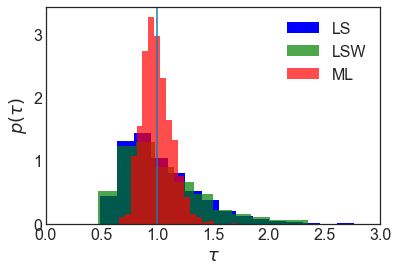

In [19]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[5],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [37]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[8]
thetaW = 1/result_array.T[6]
omegaW = 1/result_array.T[9]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [39]:
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS std (real): 0.390758506699
Decay time LS std (fit): 0.0164823055419
Decay time LS std (fit corrected): 0.0165825508006
Decay time LSW std (real): 0.438437301249
Decay time LSW std (fit): 0.182705545682
Decay time LSW std (fit corrected): 0.0165825508006
Decay time Bayes std (real): 0.133071096251
Decay time Bayes std (fit): 0.141744498927


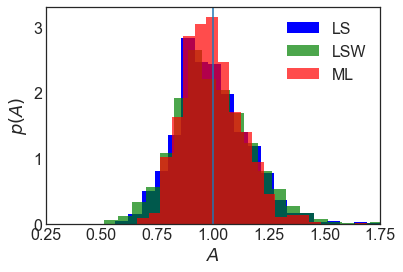

In [40]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[7],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [41]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.998396475388
Amplitude LS std (real): 0.161899147338
Amplitude LS std (fit): 0.0114510903138
Amplitude LS std (fit corrected): 0.0113988446002
Amplitude LSW std (real): 0.176006706081
Amplitude LSW std (fit): 0.0142686528781
Amplitude LSW std (fit corrected): 0.0113988446002
Amplitude Bayes mean (real): 0.997443255947
Amplitude Bayes std (real): 0.131827476656
Amplitude Bayes std (fit): 0.141053587623


In [ ]:
#decay correlation
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],result_array.T[3],result_array.T[0],result_array.T[1]):
    print(i,a,da,t,dt)

In [ ]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="blue",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=3,color="orange",label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
print(plt.style.available)